In [2]:
#importing the required libraries

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dropout, Dense, Input
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

#from keras.callbacks import TensorBoard,ModelCheckpoint
#from sklearn.metrics import f1_score 
#from sklearn.utils import shuffle 

In [4]:
initial_learning_rate = 1e-4
Epochs = 20
Batch_size = 32

directory = 'C:\\Users\\Akshita\\Desktop\\facemaskdetection\\dataset\\train'
categories = ['with_mask','without_mask']
print ('loading images...')

loading images...


In [5]:
data = []
labels = []

for category in categories:
    path = os.path.join(directory,category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = load_img(img_path,target_size = (224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

C:\Users\Akshita\anaconda3\lib\site-packages\PIL\Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000001B9283D48B0>

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype = 'float32')
labels = np.array(labels)

In [7]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(data,labels,test_size = 0.20,stratify = labels, random_state = 42)

In [8]:
aug = ImageDataGenerator(
rotation_range = 20,
zoom_range = 0.15,
width_shift_range = 0.2,
height_shift_range = 0.2,
shear_range = 0.15,
horizontal_flip = True,
fill_mode = 'nearest')

In [10]:
baseModel = MobileNetV2(weights = 'imagenet', include_top = False,input_tensor = Input(shape = (224,224,3)))

headmodel = baseModel.output
headmodel = AveragePooling2D(pool_size = (7,7))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(128,activation = 'relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(2,activation = 'softmax')(headmodel)

model = Model(inputs = baseModel.input, outputs = headmodel)

for layer in baseModel.layers:
    layer.trainable = False
    
print("compiling model")
opt = Adam(learning_rate = initial_learning_rate, decay = initial_learning_rate/Epochs)
model.compile(optimizer = opt, loss = 'binary_crossentropy',metrics = ['accuracy'])   
print('training model...')

compiling model
training model...


In [11]:
H = model.fit(
aug.flow(Xtrain, Ytrain,batch_size = Batch_size),
steps_per_epoch = len(Xtrain) // Batch_size,
validation_data = (Xtest, Ytest),
validation_steps = len(Xtest) // Batch_size,
epochs = Epochs)

print('Evaluating network...')
predIdxs = model.predict(Xtest,batch_size = Batch_size)

Epoch 1/20
32/32 [==============================] - 53s 999ms/step - loss: 0.5771 - accuracy: 0.7560 - val_loss: 0.2288 - val_accuracy: 0.9806
Epoch 2/20
32/32 [==============================] - 28s 888ms/step - loss: 0.2551 - accuracy: 0.9427 - val_loss: 0.1153 - val_accuracy: 0.9922
Epoch 3/20
32/32 [==============================] - 32s 1s/step - loss: 0.1643 - accuracy: 0.9658 - val_loss: 0.0744 - val_accuracy: 0.9922
Epoch 4/20
32/32 [==============================] - 32s 1s/step - loss: 0.0967 - accuracy: 0.9865 - val_loss: 0.0551 - val_accuracy: 0.9922
Epoch 5/20
32/32 [==============================] - 35s 1s/step - loss: 0.0807 - accuracy: 0.9879 - val_loss: 0.0429 - val_accuracy: 0.9922
Epoch 6/20
32/32 [==============================] - 37s 1s/step - loss: 0.0623 - accuracy: 0.9851 - val_loss: 0.0367 - val_accuracy: 0.9922
Epoch 7/20
32/32 [==============================] - 39s 1s/step - loss: 0.0598 - accuracy: 0.9897 - val_loss: 0.0322 - val_accuracy: 0.9922
Epoch 8/20
32/

In [12]:
predIdxs = np.argmax(predIdxs, axis = 1)

print(classification_report(Ytest.argmax(axis = 1),predIdxs, target_names = lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       132
without_mask       0.99      1.00      1.00       126

    accuracy                           1.00       258
   macro avg       1.00      1.00      1.00       258
weighted avg       1.00      1.00      1.00       258



In [13]:
print("saving mask detector model...")
model.save('mask_detector.model',save_format = 'h5')

saving mask detector model...


C:\Users\Akshita\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


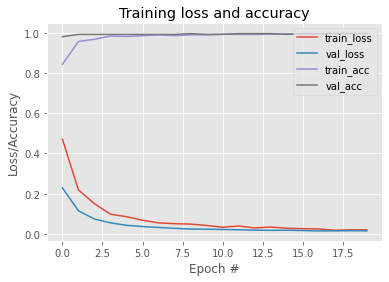

In [18]:
N = Epochs
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N),H.history["loss"],label = 'train_loss')
plt.plot(np.arange(0,N),H.history["val_loss"],label = 'val_loss')
plt.plot(np.arange(0,N),H.history["accuracy"],label = 'train_acc')
plt.plot(np.arange(0,N),H.history["val_accuracy"],label = 'val_acc')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc = 'upper right')
plt.savefig('plot.png')